## Analysis of Taxonomy
This is a script to analyze the taxonomy files (with and without abundances)

In [7]:
#import libraries in python3 kernel
import pandas as pd
import seaborn as sns
import glob
import os
import boto
import matplotlib.pyplot as plt
import numpy as np
import skbio
from Bio import SeqIO
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.SeqUtils import GC
from collections import defaultdict
from collections import Counter
import statistics
%matplotlib inline

Adapt manifest and metadata files
This function outputs MERGED which is a table with the metadata attached to each ASV ids along with their respetive abundances. It takes as an input:
all_merged: output of consolidate_tables.py


In [5]:
#paths to files needed as inputs for respective functions
all_merged_path = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/merged_all_18s_tables.tsv'
manifestfile_path = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/16S/02-PROKs/MANIFEST.tsv'
metadatafile_path = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/16S/Runs_46_47_55_18years_SPOT_USC_2/METADATA_F08.tsv'
path_to_tsvs = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/'
path_to_bacaro = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/TD_metric/Bacaros_Beta/all18slvl4/all_18s_stagg_taxo.csv'
expected_file = 'expected_18s_staggered'

In [16]:
def adapt_metadata(all_merged, manifestfile, metadatafile):
    df = pd.read_csv(all_merged, sep='\t')
    tables = df[['sample_name', 'feature_id', 'feature_frequency']].copy()
    tables.rename(columns={'sample_name':'file'}, inplace=True)
    manifest = pd.read_csv(manifestfile, sep='\t')
    manifest['file'] = [s.split('SPOT_USC_2/')[1] for s in manifest['absolute-filepath']]
    manifest['file'] = [s.split('.R')[0] for s in manifest['file']]
    manifest = manifest.drop(columns = ['absolute-filepath', 'direction'])
    manifest.drop_duplicates()
    merged = pd.merge(tables,manifest, on='file')
    merged = merged.drop(columns = ['file'])
    merged = merged.drop_duplicates()
    print('Set up manifest ...')
    metadata = pd.read_csv(metadatafile, sep='\t')
    merged = pd.merge(merged,metadata, on='sample-id')
    print('Set up metadata ...')
    merged.to_csv('filtering_asvs.tsv', sep = '\t')
    print('Saved filtering_asvs.tsv')
    return merged

In [21]:
merged = adapt_metadata(all_merged_path, manifestfile_path, metadatafile_path)
print(merged)

Set up manifest ...
Set up metadata ...
Saved filtering_asvs.tsv
                              feature_id  feature_frequency     sample-id  \
0       f3a9ea096119c0864c709dcd9cb5b757               64.0  R46-16E18E-2   
1       80ada5f4f957f6ea5231c8e04d5508ee                0.0  R46-16E18E-2   
2       e2109548bf8693aa317aaa57fe0f76ef                0.0  R46-16E18E-2   
3       dba533825fc3f801c73417026a7fd0ae               31.0  R46-16E18E-2   
4       33b0dba767b1f8cf5b68092a5f08f4de                0.0  R46-16E18E-2   
...                                  ...                ...           ...   
623833  e5c2107142423a0a00075f65018fe8eb                0.0     R46-V2E-1   
623834  30471e43bccfafef06141ea9747a72c9                0.0     R46-V2E-1   
623835  8cb4156b0661f2a9a6cab15c645ddd04                1.0     R46-V2E-1   
623836  7d18f2dc6ea1802b513dca127fda429f                0.0     R46-V2E-1   
623837  cffe67f2c0c0eea823272a4260032374                0.0     R46-V2E-1   

        ru

In [30]:
def get_abundances(path, composition, runnumber):
    files = glob.glob('{0}*.tsv'.format(path))
    taxos = []
#    if not os.path.exists(path+composition):
#        os.mkdir(path+composition)
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        tax['table_id'] = str(filename.split('/')[-1])
        tax["table_id"] = tax["table_id"].str.replace(".tsv", "")
        tax['Forward_trim'], tax['Reverse_trim'] = tax['table_id'].str.split('R', 1).str
        tax['Forward_trim'] = tax['Forward_trim'].map(lambda x: x.lstrip('F'))
        taxos.append(tax)
        print('Appended {0}'.format(filename))
    taxos = pd.concat(taxos)
    taxos = taxos.rename(columns={"Feature ID": "feature_id"}, errors="raise")
    new = taxos.merge(merged, how='left', on='feature_id')
    return new

In [33]:
new = get_abundances(path_to_tsvs, 'Staggered', '46')
new

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_89647/736829518.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  tax["table_id"] = tax["table_id"].str.replace(".tsv", "")
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_89647/736829518.py:10: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  tax['Forward_trim'], tax['Reverse_trim'] = tax['table_id'].str.split('R', 1).str


Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F250R10.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F20R10.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F200R0.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F150R80.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F130R250.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F120R250.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F30R120.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F20R120.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F180R60.tsv
Appended /Users/Diana/Docume

Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F120R120.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F130R120.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F170R20.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F20R250.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F30R250.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F230R100.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F220R100.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F0R210.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F210R190.tsv
Appended /Users/Diana/Do

Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F210R20.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F50R40.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F220R40.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F180R0.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F0R170.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F220R260.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F230R260.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F30R130.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F20R130.tsv
Appended /Users/Diana/Documen

Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F270R150.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F260R150.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F60R200.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F70R200.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F90R180.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F100R0.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F80R180.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F10R10.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F260R10.tsv
Appended /Users/Diana/Docume

Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F230R160.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F0R270.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F60R0.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F70R90.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F200R90.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F50R240.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F180R220.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F40R240.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F190R220.tsv
Appended /Users/Diana/Documen

Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F70R220.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F60R220.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F260R170.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F270R170.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F210R0.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F210R70.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F60R70.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F120R80.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F220R10.tsv
Appended /Users/Diana/Docume

Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F10R280.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F120R160.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F130R160.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F170R60.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F240R90.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F30R90.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F160R220.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F170R220.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F60R150.tsv
Appended /Users/Diana/Doc

Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F250R140.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F90R0.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F80R50.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F200R200.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F0R180.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F0R20.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F210R200.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F120R20.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F150R60.tsv
Appended /Users/Diana/Documents

Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F90R270.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F140R210.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F80R270.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F150R210.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F240R30.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F30R30.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F160R280.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F170R280.tsv
Appended /Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/F40R70.tsv
Appended /Users/Diana/Docu

feature_id  \
0       bea85d0566b992c48bd28d3300d6791d   
1       bea85d0566b992c48bd28d3300d6791d   
2       bea85d0566b992c48bd28d3300d6791d   
3       bea85d0566b992c48bd28d3300d6791d   
4       bea85d0566b992c48bd28d3300d6791d   
...                                  ...   
963288  fd7a3efed0e1ef66365e6b6b2a0df06c   
963289  fd7a3efed0e1ef66365e6b6b2a0df06c   
963290  fd7a3efed0e1ef66365e6b6b2a0df06c   
963291  fd7a3efed0e1ef66365e6b6b2a0df06c   
963292  fd7a3efed0e1ef66365e6b6b2a0df06c   

                                                    Taxon  Confidence  \
0       d__Eukaryota; p__Protalveolata; c__Syndiniales...    0.995157   
1       d__Eukaryota; p__Protalveolata; c__Syndiniales...    0.995157   
2       d__Eukaryota; p__Protalveolata; c__Syndiniales...    0.995157   
3       d__Eukaryota; p__Protalveolata; c__Syndiniales...    0.995157   
4       d__Eukaryota; p__Protalveolata; c__Syndiniales...    0.995157   
...                                                   ...         ...   
963288  d__Eukaryota; p__Protalveolata; c__Syndiniales...    0.718664   
963289  d__Eukaryota; p__Protalveolata; c__Syndiniales...    0.718664   
963290  d__Eukaryota; p__Protalveolata; c__Syndiniales...    0.718664   
963291  d__Eukaryota; p__Protalveolata; c__Syndiniales...    0.718664   
963292  d__Eukaryota; p__Protalveolata; c__Syndiniales...    0.718664   

        table_id Forward_trim Reverse_trim  feature_frequency     sample-id  \
0        F250R10          250           10              643.0  R46-16E18E-2   
1        F250R10          250           10              901.0  R46-16E18S-1   
2        F250R10          250           10              627.0  R46-16S18E-1   
3        F250R10          250           10              369.0  R46-16S18S-1   
4        F250R10          250           10              619.0  R46-16S18S-2   
...          ...          ...          ...                ...           ...   
963288  F240R230          240          230                0.0  R46-16S18S-2   
963289  F240R230          240          230                0.0     R46-18E-1   
963290  F240R230          240          230                0.0     R46-18E-2   
963291  F240R230          240          230                2.0     R46-18S-1   
963292  F240R230          240          230                0.0     R46-18S-2   

        run-number community composition  
0               46     Mixed     16E-18S  
1               46     Mixed     16E-18S  
2               46     Mixed     16S-18E  
3               46     Mixed   Staggered  
4               46     Mixed   Staggered  
...            ...       ...         ...  
963288          46     Mixed   Staggered  
963289          46       18S        Even  
963290          46       18S        Even  
963291          46       18S   Staggered  
963292          46       18S   Staggered  

[963293 rows x 11 columns]

In [ ]:
def load_df(path, composition, runnumber, foldername):
    files = glob.glob('{0}*.tsv'.format(path))
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        tax = tax.rename(columns={"Feature ID": "feature_id"}, errors="raise")
        new = tax.merge(merged, how='left', on='feature_id')
        new = new.drop(['Confidence', 'sample-id'], axis=1)
        new = new.drop_duplicates()
        new = new[new["community"] == '18S']
        new = new[new["composition"] == composition]
        new['run-number']= new['run-number'].astype(str)
        new = new[new["run-number"] == runnumber]
        new.to_csv(filename.split(foldername)[0]+foldername+'/'+composition+'/'+runnumber+filename.split(foldername+'/')[1], sep = '\t')
        return files

Once all taxonomies are in the same folder, run Bacaro's delta T measure over desired taxonomic level (1 to 7)

In [18]:
def hm(path, truthfilename):
    bacaros_dm = pd.read_csv(path)
    bacaros_dm = bacaros_dm.set_index('Unnamed: 0')
    bacaros_dm = 1  - bacaros_dm
    #bacaros_dm is a distance matrix of table X table
    my_pcoa = skbio.stats.ordination.pcoa(bacaros_dm.values)
    plt.scatter(my_pcoa.samples['PC1'],  my_pcoa.samples['PC2'])
    against_exp = bacaros_dm[[truthfilename]].copy()
    against_exp = against_exp.reset_index().rename(columns={against_exp.index.name:'sample_name'})
    against_exp.drop(against_exp.index[against_exp['sample_name'] == truthfilename], inplace=True)
    against_exp['Forward_trim'] = [s.split('R')[0] for s in against_exp['sample_name']]
    against_exp['Forward_trim'] = [s.split('46F')[1] for s in against_exp['Forward_trim']]
    against_exp['Reverse_trim'] = [s.split('R')[1] for s in against_exp['sample_name']]
    against_exp["Forward_trim"] = pd.to_numeric(against_exp["Forward_trim"])
    against_exp["Reverse_trim"] = pd.to_numeric(against_exp["Reverse_trim"])
    tohm = against_exp.pivot("Forward_trim", "Reverse_trim", "expected_18s_staggered")
    ax = sns.heatmap(tohm)
    ax.invert_yaxis()
    return (tohm, bacaros_dm)

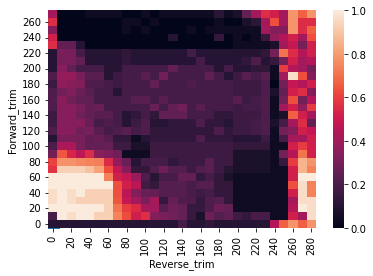

In [19]:
tohm, bacaros_dm = hm(path_to_bacaro, expected_file)